In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [91]:
df = pd.read_csv("spam.csv", encoding='ISO-8859-1')


In [93]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [94]:
print("Number of rows are: ",df.shape[0])
print("Number of columns are: ",df.shape[1]) 

Number of rows are:  5572
Number of columns are:  5


In [96]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [98]:
dup = df.duplicated().sum()
print(f'number of duplicated rows are {dup}') 

number of duplicated rows are 403


In [99]:
df.isnull().sum() 

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [100]:
df.columns 

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [102]:
df.describe(include= 'all').round(2) 

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [103]:
for i in df.columns.tolist():
    print("No. of unique values in",i,"is",df[i].nunique()) 

No. of unique values in v1 is 2
No. of unique values in v2 is 5169
No. of unique values in Unnamed: 2 is 43
No. of unique values in Unnamed: 3 is 10
No. of unique values in Unnamed: 4 is 5


In [104]:
df.rename(columns={"v1": "Category", "v2": "Message"}, inplace=True) 

In [105]:
df.drop(columns={ 'Unnamed: 2','Unnamed: 3','Unnamed: 4'}, inplace=True) 

In [109]:
df['Spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)


In [110]:
df.head() 

,Category,Message,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


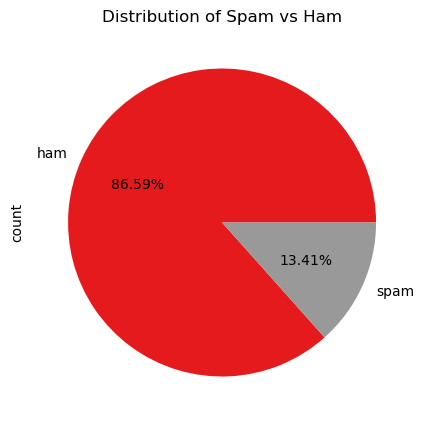

In [111]:
spread = df['Category'].value_counts()
plt.rcParams['figure.figsize'] = (5, 5)
spread.plot(kind='pie', autopct='%1.2f%%', cmap='Set1')
plt.title('Distribution of Spam vs Ham')
plt.show()

In [113]:
df_spam = df[df['Category']=='spam'].copy() 

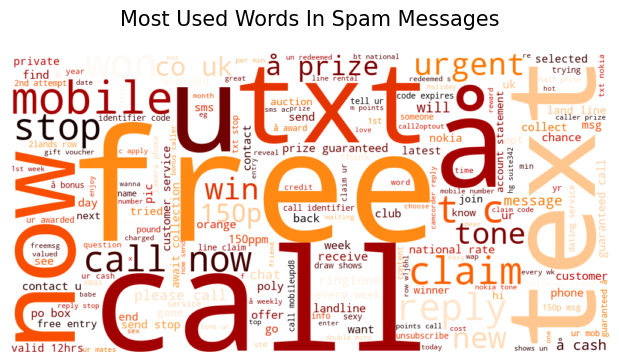

In [116]:
# Initialize an empty string for all comment words
comment_words = ""

# Set stopwords
stopwords = set(STOPWORDS) 

# Concatenate all spam messages into a single string
for val in df_spam['Message']:
    # Typecast each message to string
    val = str(val)
    
    # Split the message into tokens
    tokens = val.split()
    
    # Convert each token to lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    # Add tokens to comment_words with a space separator
    comment_words += " ".join(tokens) + " "

# Generate word cloud with specified parameters
wordcloud = WordCloud(width=1000, height=500,
                      background_color='white',
                      stopwords=stopwords,
                      min_font_size=10,
                      max_words=1000,
                      colormap='gist_heat_r').generate(comment_words)

# Plotting the word cloud
plt.figure(figsize=(6, 6), facecolor=None)
plt.title('Most Used Words In Spam Messages', fontsize=15, pad=20)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)

# Display the chart
plt.show()

In [118]:
X_train, X_test, y_train, y_test = train_test_split(df['Message'], df['Spam'], test_size=0.2, random_state=42)

In [119]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    The function will take model, X_train, X_test, y_train, y_test, 
    fit the model, make predictions, and print various evaluation metrics.
    It will return the following scores as a list:
    precision_train, precision_test, recall_train, recall_test, acc_train, acc_test, roc_auc_train, roc_auc_test
    """
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the training and test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    pred_prob_train = model.predict_proba(X_train)[:, 1]
    pred_prob_test = model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC AUC score
    roc_auc_train = roc_auc_score(y_train, pred_prob_train)
    roc_auc_test = roc_auc_score(y_test, pred_prob_test)
    print("\nTrain ROC AUC:", roc_auc_train)
    print("Test ROC AUC:", roc_auc_test)
    
    # Plot the ROC curve
    fpr_train, tpr_train, _ = roc_curve(y_train, pred_prob_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, pred_prob_test)
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_train, tpr_train, label=f"Train ROC AUC: {roc_auc_train:.2f}")
    plt.plot(fpr_test, tpr_test, label=f"Test ROC AUC: {roc_auc_test:.2f}")
    plt.legend()
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    
    # Calculate confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    
    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=ax[0], xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    ax[0].set_title("Train Confusion Matrix")
    
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", ax=ax[1], xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")
    ax[1].set_title("Test Confusion Matrix")
    
    plt.tight_layout()
    plt.show()
    
    # Calculate classification report
    cr_train = classification_report(y_train, y_pred_train, output_dict=True)
    cr_test = classification_report(y_test, y_pred_test, output_dict=True)
    print("\nTrain Classification Report:")
    print(pd.DataFrame(cr_train).T.to_markdown())
    print("\nTest Classification Report:")
    print(pd.DataFrame(cr_test).T.to_markdown())
    
    # Extract metrics
    precision_train = cr_train['weighted avg']['precision']
    precision_test = cr_test['weighted avg']['precision']
    recall_train = cr_train['weighted avg']['recall']
    recall_test = cr_test['weighted avg']['recall']
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    roc_auc_train = roc_auc_train
    roc_auc_test = roc_auc_test
    
    # Return the evaluation scores
    return [precision_train, precision_test, recall_train, recall_test, acc_train, acc_test, roc_auc_train, roc_auc_test]


Train ROC AUC: 0.9937259700922575
Test ROC AUC: 0.9792158894645941


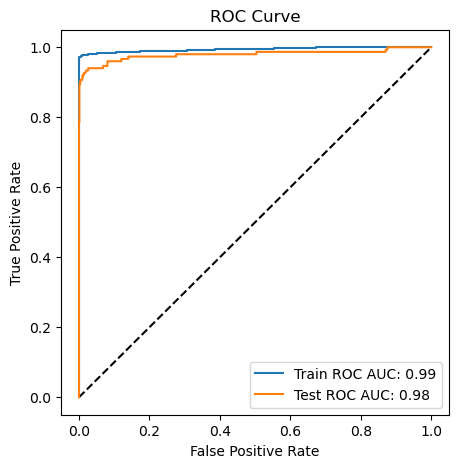

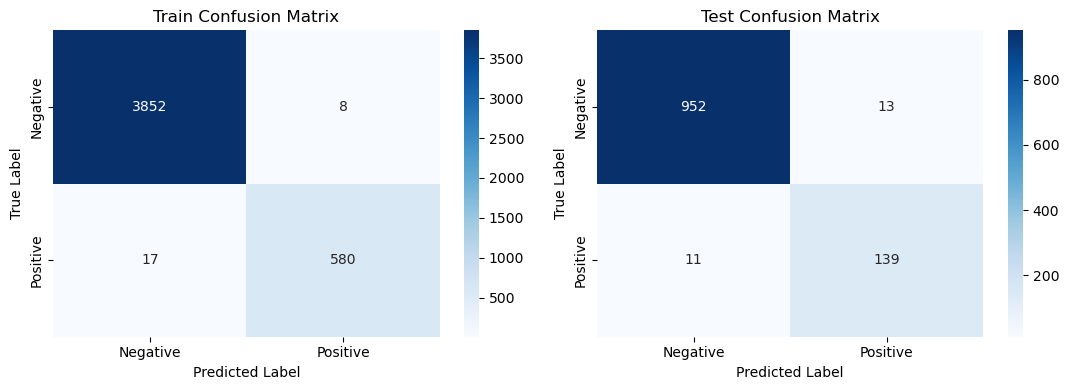


Train Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.995606 | 0.997927 |   0.996765 | 3860        |
| 1            |    0.986395 | 0.971524 |   0.978903 |  597        |
| accuracy     |    0.994391 | 0.994391 |   0.994391 |    0.994391 |
| macro avg    |    0.991    | 0.984726 |   0.987834 | 4457        |
| weighted avg |    0.994372 | 0.994391 |   0.994373 | 4457        |

Test Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.988577 | 0.986528 |   0.987552 |  965        |
| 1            |    0.914474 | 0.926667 |   0.92053  |  150        |
| accuracy     |    0.978475 | 0.978475 |   0.978475 |    0.978475 |
| macro avg    |    0.951526 | 0.956598 |   0.954041 | 1115        |
| weighted avg |    0.978608 | 0.978475 |   

In [125]:
from sklearn.metrics import roc_auc_score, roc_curve,classification_report
import matplotlib.pyplot as plt

# Step 1: Vectorize the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Message'])  # df['Message'] contains the text data

# Step 2: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Spam'], test_size=0.2, random_state=42)

# Step 3: Instantiate and fit the model
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Step 4: Evaluate the model using the evaluate_model function
MultinomialNB_score = evaluate_model(clf, X_train, X_test, y_train, y_test)
print("Evaluation Scores:", MultinomialNB_score)


In [143]:
def detect_spam(email_text):
    # Vectorize the input email text using the same vectorizer used for training
    email_vector = vectorizer.transform([email_text])
    
    # Make a prediction using the trained classifier
    prediction = clf.predict(email_vector)
    if prediction[0] == 0:
        return "This is a Ham Email!"
    else:
        return "This is a Spam Email!"


In [145]:
# Example of how to use the function
sample_email = 'Free Tickets for IPL'
result = detect_spam(sample_email)
print(result)


This is a Spam Email!
